# CSE152B: Homework 2
## Computing Resources
Please read the README file of this repository for the instructions
## Instructions
1. Attempt all questions.
2. Please comment all your code adequately.
3. Include all relevant information such as text answers, output images in notebook.
4. **Academic integrity:** The homework must be completed individually.

5. **Submission instructions:**  
 (a) Submit the notebook and its PDF version on Gradescope.  
 (b) Rename your submission files as Lastname_Firstname.ipynb and Lastname_Firstname.pdf.  
 (c) Correctly select pages for each answer on Gradescope to allow proper grading.

6. **Due date:** Assignments are due Thu, May 21, at 4pm. 

Git clone the repo of HW2:
```
git clone https://github.com/Jerrypiglet/cse152b_hw2-release.git
cd cse152b_hw2-release
```

## Q1: Using SphereFace [3] for Face Verification

1. In the first section, we will test a pretrained model of SphereFace on LFW [4] dataset. The LFW dataset is on `/datasets/cse152-252-sp20-public/hw2_data/lfw`. The dataset contains 6000 pairs of human face images with ground truth labels for whether they are from the same identity.
2. The PyTorch code of SphereFace is located in `./sphereFace`,  which is modified based on the open source code from `https://github.com/clcarwin/sphereface_pytorch`. 
3. Run the following commands and report the accuracy of SphereFace on LFW verification. **(5 points)**
```
cd sphereFace
tar -zxf model.tar.gz
python lfw_eval.py --model ./model/sphere20a_20171020.pth --net faceNet --lfw /datasets/cse152-252-sp20-public/hw2_data/lfw/
```

The accuracy of SphereFace is 99.18%.  
LFWACC=0.9918 std=0.0051 thd=0.3095

4. Explain briefly how the following steps are performed when evaluating on LFW dataset: 
    1. Given the features extracted from the network, what is the metric used to measure the distance between two faces? (`lfw_eval.py`: Line 135) **(5 points)**
    2. How is the threshold set to determine whether two faces are from the same identity? How is the accuracy computed? (`lfw_eval.py`: Line 141 to 148) **(10 points)**

A. The metric used to mesure the distance is cosine similarity. It calcualtes the angle between two vectors and used the angle between them to measure their relative similarity. If two factors are in the same direction, then their angle will be 0 degree which corresponds to cosine equals 1, meaning they are the same. If they are in the opposite direction, then the cosine of the angle will be 0, indicating no similarity.

B. The threshold is set by iteraively check the accuracy using each threshold on the training set and pick the one with best accuracy. The final accuracy is calcualted by averaging the accuracies of trails. Each trail is calculated by holding out different portion of dataset, using the rest as training set to train the model, and evaluating accuracy on the hold-out set.

5. An important step before face recognition is face alignment, in which we warp and crop the image based on the location of facial landmarks.
    1. Briefly describe how we warp and crop the image. (`lfw_eval.py`: Line 11-26) **(5 points)**
    2. Instead of doing face alignment, crop an image patch of height 112 pixels and width 96 pixels at the center of the image. Report the accuracy.  **(10 points)**

A. First we have a set of reference points, which define the desire arrangement of input images. Then we get the optimal transformation predicted by the model, which is a 2x3 matrix with parameters. Then we use the matrix to get the affine transformation of the input image.  
B. The accuracy is 58.03%.
LFWACC=0.5803 std=0.0198 thd=0.7210

## Q2: Using MTCNN [5] for Detecting Face Landmarks

1. Instead of using provided facial landmarks, we will now use MTCNN [5] for detecting them. The code is located at `./mtcnn`. Run the following commands to generate the facial landmarks. Include two example outputs in your report. **(5 points)**
```
cd MTCNN 
python lfw_landmark.py --lfw /datasets/cse152-252-sp20-public/hw2_data/lfw/
```

AJ_Cook/AJ_Cook_0001.jpg	103.672	114.958	146.303	109.461	118.223	135.837	110.155	158.646	149.281	154.148	
AJ_Lamas/AJ_Lamas_0001.jpg	104.424	111.958	149.001	118.325	130.224	134.433	97.063	152.340	147.845	158.792	

2. Go to the `sphereFace` directory, run the following commands by setting flag `alignmentMode` to be 2. Report the error using the predicted facial landmarks. **(5 points)**
```
cd sphereFace
python lfw_eval.py --model ./model/sphere20a_20171020.pth --net faceNet --lfw /datasets/cse152-252-sp20-public/hw2_data/lfw/ --alignmentMode 2
```

The error rate is 98.45%.
LFWACC=0.9845 std=0.0057 thd=0.2995

3. Next, answer the following questions:
    1. Is the result better than using the landmarks provided in the previous question? If not, how can you improve performance? **(5 points)**
    2.  What are the steps adopted by the method to achieve real-time speed? **(5 points)**
    3. Briefly describe how non-maximal suppression (NMS) is implemented in this method. (`src/box_utils.py`: Line 5-68) **(5 points)**

A. The result isn't better than using the landmark provided. One way to improve performance is to use a bigger size of training images that share the similar characteristic with the test images(coming from the same pool).  
B. It uses convolution filters with less size to reduce computations, while building a deeper network to increase the performance.  
C. It repeatedly find the intersection using the top 2 samples with the best score in the remaining array, and determine the intersection threshold based on the mode, then exclude samples that has overlapping less than the threshold.

## Q3: Training CosFace [7] on CASIA Dataset [6]

In this section, you are required to implement CosFace based on the code you use in the previous section, train it on CASIA dataset and test on LFW dataset. 
1. You will now train CosFace [7] on the CASIA dataset [6] and test on the LFW dataset [4]. In this section, the skeleton code for training is given. CASIA-Webface dataset can be found at `/datasets/cse152-252-sp20-public/hw2_data/CASIA-WebFace`.  

Go to directory `./cosFace` and open `faceNet.py`. Under class `CustomLienar` implement function $\psi(\theta_{y_i}, i)  = \cos(\theta_{y_i}, i) - m$ which is the cosine distance with margin $m$.
Under class `CustomLoss`, implement the loss function with the returned $\psi(\theta_{y_i}, i)$ and $\cos(\theta_{j}, i)$. You may check (and duly cite) any open source implementation for hints on improving the performance. **(15 points)**

class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, m = 0.35):
        super(CustomLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(in_features,out_features) )
        self.weight.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = m

    def forward(self, input):
        x = input   # size=(B,F)    F is feature len
        w = self.weight # size=(F,Classnum) F=in_features Classnum=out_features

        ww = w.renorm(2,1,1e-5).mul(1e5)
        xlen = x.pow(2).sum(1).pow(0.5) # size=B
        wlen = ww.pow(2).sum(0).pow(0.5) # size=Classnum

        cos_theta = x.mm(ww) # size=(B,Classnum)
        cos_theta = cos_theta / torch.clamp(xlen.view(-1,1) * wlen.view(1,-1), min=1e-8 )
        cos_theta = cos_theta.clamp(-1,1)

        # IMPLEMENT phi_theta
        phi_theta = cos_theta - self.m

        output = (cos_theta, phi_theta)
        output = (cos_theta, self.m)
        return output


class CustomLoss(nn.Module):
    def __init__(self, s=64 ):
        super(CustomLoss, self).__init__()
        self.s = s

    def forward(self, input, target):
        cos_theta,m = input
        target = target.view(-1,1) #size=(B,1)

        # IMPLEMENT loss
        nllloss = nn.CrossEntropyLoss().cuda()
        B, Classnum = cos_theta.shape
    
        one_hot = torch.zeros_like(cos_theta)
        one_hot.scatter_(1, target, 1.0)
        output = self.s * (cos_theta - one_hot * m)
        loss = nllloss(output, target[:,0])
    
        _, predictedLabel = torch.max(cos_theta.data, 1)
        predictedLabel = predictedLabel.view(-1, 1)
        accuracy = (predictedLabel.eq(target.data).cpu().sum().item() ) / float(target.size(0) )

        return loss, accuracy
        
        
I changed the parameter I passed into loss function because it would allow me to make modification on the matrix easier.

2. The original architecture of FaceNet in ``cosFace/FaceNet.py`` is a 20-layer residual network as described in Table 2 of [3], but without batch normalization. Now add batch normalization after every convolutional and fully connected layer. Train the new network on CASIA dataset and test on LFW dataset. You are free to change any hyper parameters but report the hyper parameters that you think might influence the performance. Following is a demonstration of a residual block with 128 filters and kernel size $3\times3$:
\begin{align}
y &=& \mathtt{CONV}_{3\times3, 128}(x) \\
y &=& \mathtt{BatchNorm}(y) \\
y &=& \mathtt{PReLU}(y) \\
y &=& \mathtt{CONV}_{3\times3, 128}(y) \\
y &=& \mathtt{BatchNorm}(y) \\
y &=& \mathtt{PReLU}(y) \\
\mathtt{OUT} &=& x + y
\end{align}
    1. Draw the training curves for accuracy and loss on CASIA and compare to the curve without batch normalization. **(10 points)**
    2. Report accuracy on the LFW dataset, evaluated using `lfw_eval.py`. **(10 points)**
    3. Do you achieve better performance on LFW? If yes, explain how batch normalization helps. If not, try to explain why the results are worse.  **(10 points)**

<img src="bn_training.png">

B. Without batch normalization, the accuracy is 95.62%.  
With batch normalization, the accuracy is 98.83%.

python lfw_eval.py --model ./checkpoint/netFinal_8.pth --net faceNet --lfw /datasets/cse152-252-sp20-public/hw2_data/lfw/  
python lfw_eval.py --model ./bn_checkpoint/bn_netFinal_8.pth --net faceNet --lfw /datasets/cse152-252-sp20-public/hw2_data/lfw/

3. If you achieve better performance compared to SphereFace in Q1, well done! Can you provide a reason? If you do not outperform SphereFace, can you provide a cause? **(10 points)**

No it didn't achieved better performance because we only limited the model to stop after 28000 iterations, so it is very likely that the model stopped before it actually converges. In theory, it would perform better because we imposed different classes would have a margin m between them.

4. Randomly choose 10 identities from the CASIA dataset, forward pass all their images through the CosFace network and visualize the normalized features (embeddings) using tSNE [8]. You can use code from https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for visualization. Try a few random samples and include the figure that you consider most illustrative of the method. **(10 points)**

<img src="3.4.png" width=50% height=50%>

## Q4: Human Pose Estimation with Convolutional Pose Machines (CPM) [1]

In this question, you will be given code adapted from [PyTorch implementation of one of the CPM model [1]](https://github.com/Hzzone/pytorch-openpose), which is an follow-up work of the original Convolution Pose Machine [2], and shares the Part Confidence Maps estimation module with [2]. In this question you will be given a trained CPM model and gain insights about the model design and outputs.

- ``cd pytorch-openpose``
- Set up the environment following the instructions at ``pytorch-openpose/README.md`` (Getting Started - Install Requriements)
- Download the ``body_pose_model.pth`` from [Dropbox](https://www.dropbox.com/sh/7xbup2qsn7vvjxo/AABWFksdlgOMXR_r5v3RwKRYa?dl=0) and place under ``pytorch-openpose/model``

1. Run the inference code on the given image.

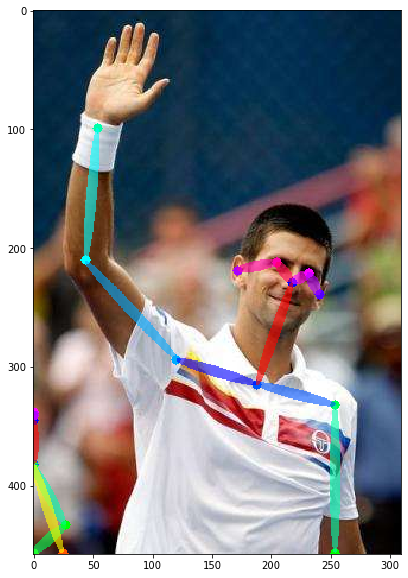

In [17]:
import cv2
import matplotlib.pyplot as plt
import copy
import numpy as np

from src import model
from src import util
from src.body import Body
from src.hand import Hand

body_estimation = Body('model/body_pose_model.pth')

test_image = 'images/demo.jpg'
oriImg = cv2.imread(test_image)  # B,G,R order
candidate, subset, heatmap_list, heatmap_list_converted_list = body_estimation(oriImg)
heatmap_0 = heatmap_list[0] 
canvas = copy.deepcopy(oriImg)
canvas = util.draw_bodypose(canvas, candidate, subset)

plt.figure(figsize=(10, 10))
plt.imshow(canvas[:, :, 
                  [2, 1, 0]])
# plt.axis('off')
plt.show()

(a) Visualize the output keypoint detection result. **(5 points)**

<img src="4.1a.png" width=50% height=50%>

(b) What is the ratio of size $\lambda=H/H'$ between the input image **im** (Line 61 of ``body.py``) 
of shape [1, 3, H, W] and the output heatmap **heatmap_0** of shape [1, D, H', W']? **(5 points)**

H is 184, H' is 23. So $\lambda=8$

(c) What module in the model is reponsible for this scaling? **(5 points)**

This scaling is achieved by torch.conv2d, torch.maxPool, and torch.cat module.

2. ``heatmap_list_converted_list[0]`` is a list of heatmaps from all 6 layers: [out1_2, out2_2, out3_2, out4_2, out5_2, out6_2], where the output of each layer is of shape [H, W, D].

This snippet gives the function to visualize the $d_{th}$ feature map from the layer **layer_idx**

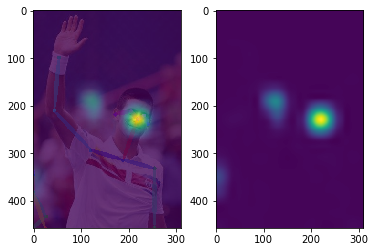

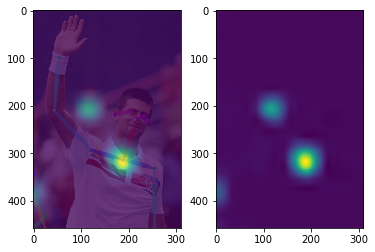

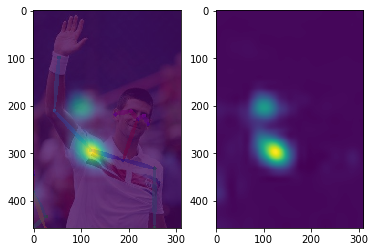

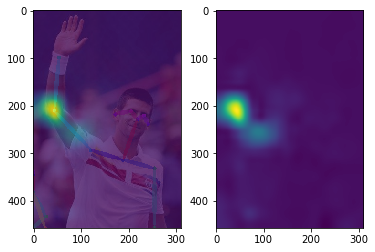

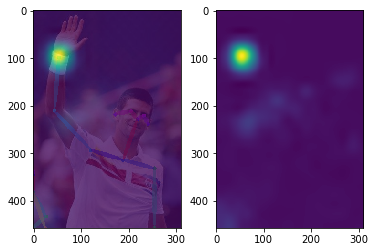

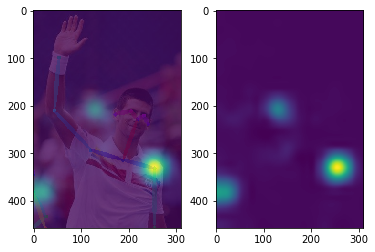

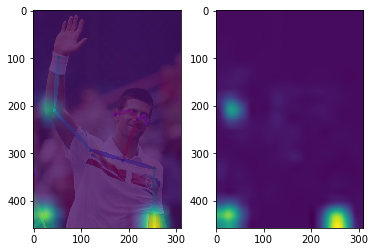

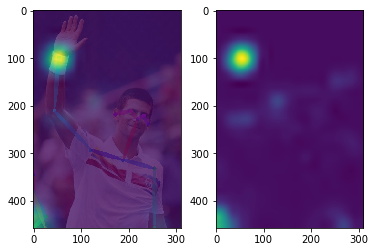

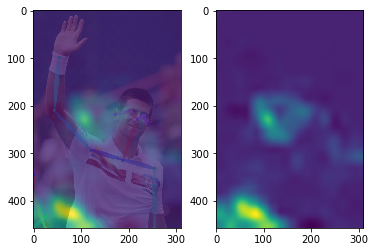

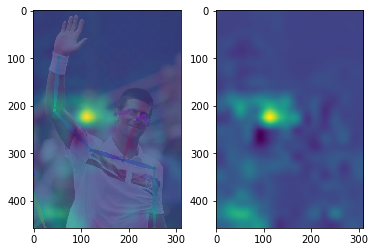

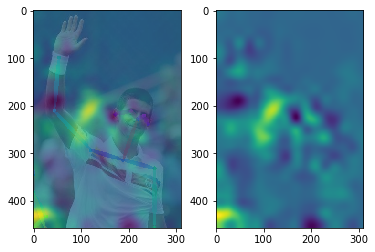

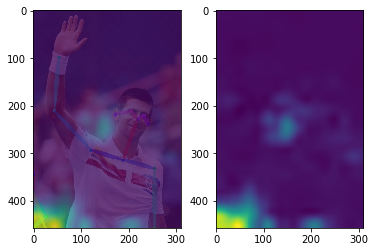

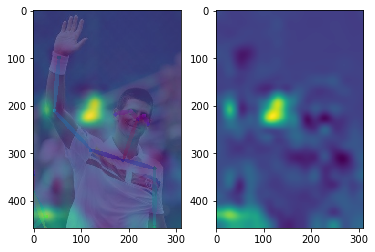

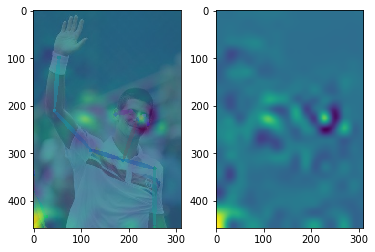

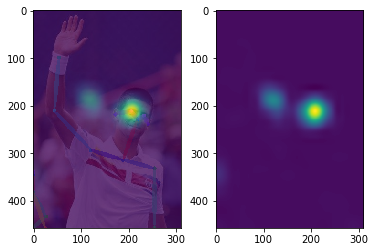

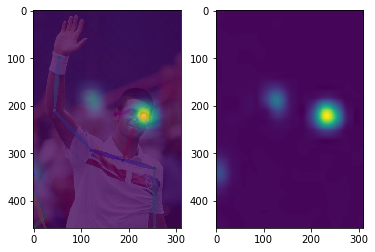

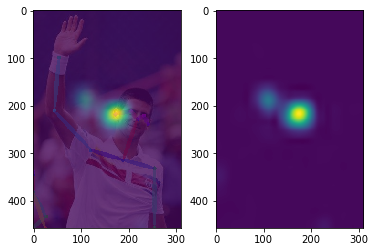

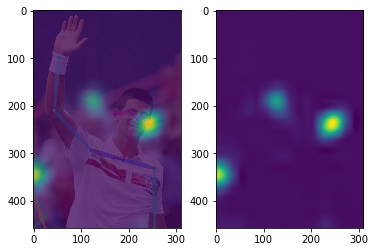

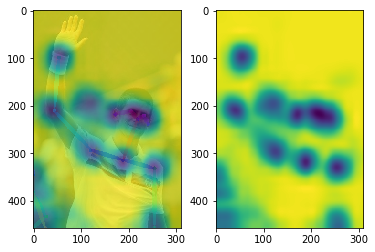

In [28]:
layer_idx = -1

for d in range(heatmap_list_converted_list[0][layer_idx].shape[2]):
    layer_idx = 0
    heatmap = heatmap_list_converted_list[0][layer_idx][:, :, d]
    util.overlay_heatmap(canvas, heatmap)

(a) What is D? And given D can you tell what is the number of keypoints that the model is trying to estimate? **(5 points)**

D is 25. The nubmer of keypoints that the model is trying to estimate is 25.

(b) Visualize and compare the heatmap from **layer_idx=0** and **layer_idx=5** for the keypoint **d=2**. **(5 points)**

layer_idx: 0


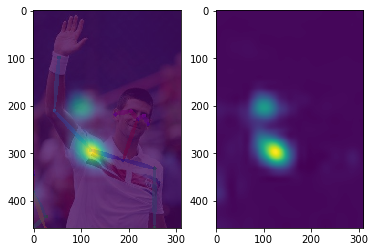

layer_idx: 5


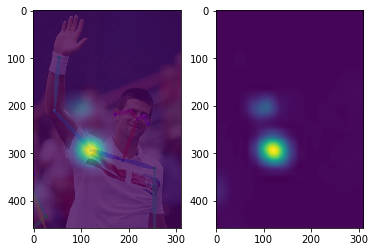

In [24]:
for layer_idx in [0,5]:
    print("layer_idx: {}".format(layer_idx))
    util.overlay_heatmap(canvas, heatmap_list_converted_list[0][layer_idx][:, :, 2])

(c) Visualize and compare the heatmap from **layer_idx=0** and **layer_idx=5** for the keypoint **d=3**. **(5 points)**

layer_idx: 0


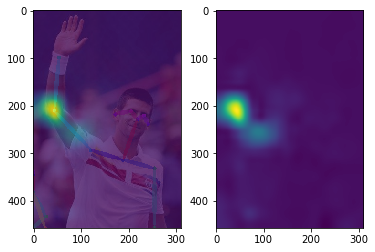

layer_idx: 5


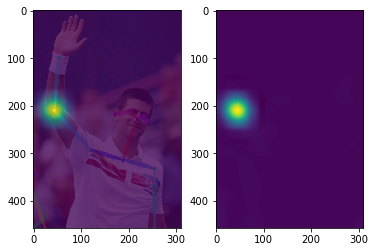

In [25]:
for layer_idx in [0,5]:
    print("layer_idx: {}".format(layer_idx))
    util.overlay_heatmap(canvas, heatmap_list_converted_list[0][layer_idx][:, :, 3])

(d) State and justify the shared difference in these comparisons? You may get some hint from the model design. **(5 points)**

The shared difference in these comparison is from layer_idx=0 to layer_idx=5, we get a more refined and accurate result, so I suppose the model used the output from previous index as the input of the next index. In such a way, we will get a more accurate estimation by refining the candidate area.

3. Set **multi_scale=True** in Line 38 of ``body.py`` and re-run the code from Q4(1). 

    (a) Visualize the output below. **(5 points)**
    
    **NOTE: you might need to restart the kernel each time you change the ``multi_scale`` flag. This may be required to re-initialize the model. [Kernel]-->[Restart]**

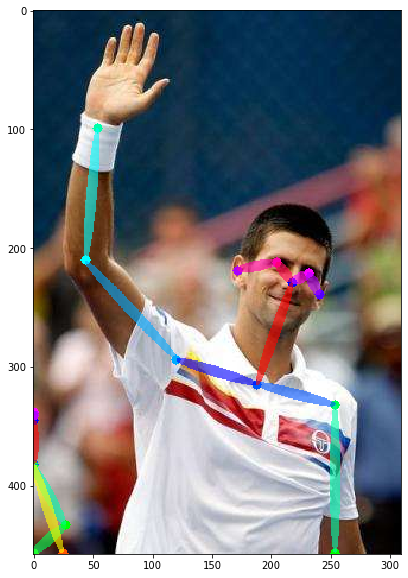

In [29]:
import cv2
import matplotlib.pyplot as plt
import copy
import numpy as np

from src import model
from src import util
from src.body import Body
from src.hand import Hand

body_estimation = Body('model/body_pose_model.pth')

test_image = 'images/demo.jpg'
oriImg = cv2.imread(test_image)  # B,G,R order
candidate, subset, heatmap_list, heatmap_list_converted_list = body_estimation(oriImg)
heatmap_0 = heatmap_list[0] 
canvas = copy.deepcopy(oriImg)
canvas = util.draw_bodypose(canvas, candidate, subset)

plt.figure(figsize=(10, 10))
plt.imshow(canvas[:, :, 
                  [2, 1, 0]])
# plt.axis('off')
plt.show()

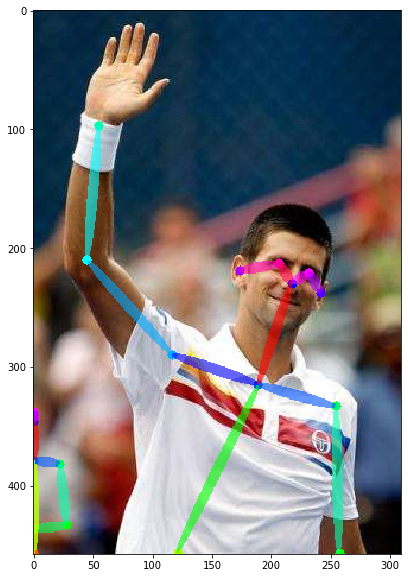

In [4]:
import cv2
import matplotlib.pyplot as plt
import copy
import numpy as np

from src import model
from src import util
from src.body import Body
from src.hand import Hand

body_estimation = Body('model/body_pose_model.pth')

test_image = 'images/demo.jpg'
oriImg = cv2.imread(test_image)  # B,G,R order
candidate, subset, heatmap_list, heatmap_list_converted_list = body_estimation(oriImg)
heatmap_0 = heatmap_list[0] 
canvas = copy.deepcopy(oriImg)
canvas = util.draw_bodypose(canvas, candidate, subset)

plt.figure(figsize=(10, 10))
plt.imshow(canvas[:, :, 
                  [2, 1, 0]])
# plt.axis('off')
plt.show()

(b) Do the same comparison with additional images of ``demo_coco.jpg``, ``demo_coco2.jpg``, ``demo_beach.jpg``, ``demo_ucsd.jpg``, ``demo_ucsd2.jpg``.  **(5 points)**

``For each of the additional images, paste two figures with multi_scale=True and multi_scale=False here``

<img src="4.3/demo_coco_1.png" width=50% height=50%>

<img src="4.3/demo_coco_2.png" width=50% height=50%>

<img src="4.3/demo_coco2_1.png" width=50% height=50%>

<img src="4.3/demo_coco2_2.png" width=50% height=50%>

<img src="4.3/demo_beach_1.png" width=50% height=50%>

<img src="4.3/demo_beach_2.png" width=50% height=50%>

<img src="4.3/demo_ucsd_1.png" width=50% height=50%>

<img src="4.3/demo_ucsd_1.png" width=50% height=50%>

(c) What shared difference can you spot in most of the comparisons? Justify the difference. **(5 points)**

The major difference is that when we set multi_scale = True, the model would be able to recognize people of more poses and views. When multi_scale=False, the model would be limited to only one pose, so the result maybe mis-classified or fewer than expected.

# Reference
[1] Cao, Zhe. et al. "Realtime multi-person 2d pose estimation using part affinity fields." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2017.

[2] Wei, Shih-En. et al. "Convolutional pose machines." Proceedings of the IEEE conference on Computer Vision and Pattern Recognition. 2016.

[3] Liu, Weiyang. et al. "SphereFace: Deep Hypersphere Embedding for Face Recognition." arXiv:1704.08063.

[4] Huang, Gary. et al. "Labeled faces in the wild:  Adatabase for studying face recognition in unconstrained environments." Technical Report 07-49, Universityof Massachusetts, Amherst, October 2007.

[5] Zhang, Kaipeng. et al. "Joint face detection and alignment usingmultitask cascaded convolutional networks." IEEE Signal Processing Letters, 23(10):1499–1503, 2016.

[6] Yi, Dong. et al.  Learning face representation from scratch. arXiv:1411.7923.

[7] Wang, Hao. et al.Cosface: Large margin cosine loss for deep face recognition. In Proceedings of the IEEE Conference onComputer Vision and Pattern Recognition, pages 5265–5274, 2018.